# Analysis of States Assignment

## Step 1: Import Data

In [1]:
#reading in the 4 files 
import pandas as pd

census_mhi = pd.read_csv('/Users/anniezeng/Desktop/CENSUS_MHI_STATE - CENSUS_MHI_STATE.csv')
census_pop = pd.read_csv('/Users/anniezeng/Desktop/CENSUS_POPULATION_STATE.tsv', sep='\t')
keys = pd.read_csv('/Users/anniezeng/Desktop/KEYS.csv')
redfin_price = pd.read_csv('/Users/anniezeng/Desktop/REDFIN_MEDIAN_SALE_PRICE.csv')

## Step 2: Preparing DataFrame for Census Population Analysis

In [2]:
# Getting the right keys and columns needed for census population
top_53_df = keys.head(53)
top_53_df = top_53_df.iloc[1:]
cols = ['key_row', 'census_msa', 'alternative_name', 'redfin_region']
result_df = top_53_df[cols].copy()

pop = census_pop.loc[1, [f"{state}!!Estimate" for state in result_df['census_msa']]].values

result_df['census_population'] = pop


In [3]:
# Population Rank 

def suf_rank(n): # Helper function for the suffix  
    if 11 <= (n % 100) <= 13:
        suffix = 'th'
    else:
        suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(n % 10, 'th')
    return str(n) + suffix

# formatting census population to int 
result_df['int_census_population'] = result_df['census_population'].str.replace(',', '').astype(int)

result_df['population_rank'] = result_df['int_census_population'].rank(method='dense', ascending=False).astype(int).apply(suf_rank)
result_df = result_df.drop('int_census_population', axis=1)

# Pop Blurb

result_df['population_blurb'] = result_df.apply(
    lambda row: f"{row['alternative_name']} is {row['population_rank']} in the nation in population among states, DC, and Puerto Rico.",
    axis=1
)
result_df[:5]

,key_row,census_msa,alternative_name,redfin_region,census_population,population_rank,population_blurb
1,alabama,Alabama,Alabama,Alabama,"5,108,468",24th,Alabama is 24th in the nation in population am...
2,alaska,Alaska,Alaska,Alaska,"733,406",49th,Alaska is 49th in the nation in population amo...
3,arizona,Arizona,Arizona,Arizona,"7,431,344",14th,Arizona is 14th in the nation in population am...
4,arkansas,Arkansas,Arkansas,Arkansas,"3,067,732",34th,Arkansas is 34th in the nation in population a...
5,california,California,California,California,"38,965,193",1st,California is 1st in the nation in population ...


## Step 3: Median Household Income Analysis

In [4]:
#median household income
mhi = census_mhi.loc[1, [f"{state}!!Median income (dollars)!!Estimate" for state in result_df['census_msa']]].values
result_df['median_household_income']= mhi
result_df['median_household_income'] = result_df['median_household_income'].apply(lambda x: f"${x}")

#mhi rank
# formatting census population to int 
result_df['int_mhi'] = result_df['median_household_income'].str.replace('[\$,]', '', regex=True).astype(int)

result_df['median_household_income_rank'] = result_df['int_mhi'].rank(method='dense', ascending=False).astype(int).apply(suf_rank)
result_df[:5]

#mhi blurb
result_df['median_household_income_blurb'] = result_df.apply(
    lambda row: f"{row['alternative_name']} is {row['median_household_income_rank']} in the nation in median household income among states, DC, and Puerto Rico.",
    axis=1
)
result_df[:5]

,key_row,census_msa,alternative_name,redfin_region,census_population,population_rank,population_blurb,median_household_income,int_mhi,median_household_income_rank,median_household_income_blurb
1,alabama,Alabama,Alabama,Alabama,"5,108,468",24th,Alabama is 24th in the nation in population am...,"$62,027",62027,47th,Alabama is 47th in the nation in median househ...
2,alaska,Alaska,Alaska,Alaska,"733,406",49th,Alaska is 49th in the nation in population amo...,"$89,336",89336,13th,Alaska is 13th in the nation in median househo...
3,arizona,Arizona,Arizona,Arizona,"7,431,344",14th,Arizona is 14th in the nation in population am...,"$76,872",76872,21st,Arizona is 21st in the nation in median househ...
4,arkansas,Arkansas,Arkansas,Arkansas,"3,067,732",34th,Arkansas is 34th in the nation in population a...,"$58,773",58773,49th,Arkansas is 49th in the nation in median house...
5,california,California,California,California,"38,965,193",1st,California is 1st in the nation in population ...,"$96,334",96334,6th,California is 6th in the nation in median hous...


## Step 4: Median Sale Price Analysis

In [5]:
#median sale price 
msp_table = redfin_price[['Month of Period End.157', 'Unnamed: 0']]

#merging result_df to msp_table for median sale price column
merged_df = pd.merge(result_df, msp_table, left_on='redfin_region', 
    right_on='Unnamed: 0', how='outer')
merged_df = merged_df.iloc[:-1, :]
merged_df.rename(columns={'Month of Period End.157': 'median_sale_price'}, inplace=True)
merged_df = merged_df.drop('Unnamed: 0', axis=1)


#missing value for puerto rico and incorrect value for Washington DC
merged_df.loc[50, 'median_sale_price'] = '$565K'
merged_df.loc[51, 'median_sale_price'] = '$138K'

#convert k to thousands 
def convert_k_to_full(value):
    value = value.strip().upper().replace('$', '').replace('K', '')
    try:
        num = float(value)
        return f"${int(num * 1000):,}"
    except ValueError:
        return None  # or return the original value if preferred

    
merged_df['median_sale_price'] = merged_df['median_sale_price'].apply(convert_k_to_full)

In [6]:
#median sale price rank 
merged_df['int_msp'] = merged_df['median_sale_price'].replace('[\$,]', '', regex=True).astype(int) #convert to int

merged_df['median_sale_price_rank'] = merged_df['int_msp'].rank(method='first',ascending=False).astype(int).apply(suf_rank)


#median sale price blurb
merged_df['median_sale_price_blurb'] = merged_df.apply(
    lambda row: f"{row['alternative_name']} has the {row['median_sale_price_rank']} highest median sale price on homes in the nation among states, DC, and Puerto Rico, according to Redfin data from February 2025.",
    axis=1
)

## Step 5: House Affordability Ratio Analysis

In [7]:
#House affordability ratio
merged_df['house_affordability_ratio'] = round(merged_df['int_msp']/merged_df['int_mhi'],1)

#House affordability rank
merged_df['house_affordability_ratio_rank'] = merged_df['house_affordability_ratio'].rank(method='min',ascending=True).astype(int).apply(suf_rank)

#House affordability blurb
merged_df['house_affordability_ratio_blurb'] = merged_df.apply(
    lambda row: f"{row['alternative_name']} has the {row['house_affordability_ratio_rank']} lowest house affordability ratio in the nation among states, DC, and Puerto Rico, according to Redfin data from February 2025.",
    axis=1
)
merged_df[:5]

,key_row,census_msa,alternative_name,redfin_region,census_population,population_rank,population_blurb,median_household_income,int_mhi,median_household_income_rank,median_household_income_blurb,median_sale_price,int_msp,median_sale_price_rank,median_sale_price_blurb,house_affordability_ratio,house_affordability_ratio_rank,house_affordability_ratio_blurb
0,alabama,Alabama,Alabama,Alabama,"5,108,468",24th,Alabama is 24th in the nation in population am...,"$62,027",62027.0,47th,Alabama is 47th in the nation in median househ...,"$283,000",283000,37th,Alabama has the 37th highest median sale price...,4.6,24th,Alabama has the 24th lowest house affordabilit...
1,alaska,Alaska,Alaska,Alaska,"733,406",49th,Alaska is 49th in the nation in population amo...,"$89,336",89336.0,13th,Alaska is 13th in the nation in median househo...,"$385,000",385000,23rd,Alaska has the 23rd highest median sale price ...,4.3,18th,Alaska has the 18th lowest house affordability...
2,arizona,Arizona,Arizona,Arizona,"7,431,344",14th,Arizona is 14th in the nation in population am...,"$76,872",76872.0,21st,Arizona is 21st in the nation in median househ...,"$456,000",456000,17th,Arizona has the 17th highest median sale price...,5.9,40th,Arizona has the 40th lowest house affordabilit...
3,arkansas,Arkansas,Arkansas,Arkansas,"3,067,732",34th,Arkansas is 34th in the nation in population a...,"$58,773",58773.0,49th,Arkansas is 49th in the nation in median house...,"$255,000",255000,43rd,Arkansas has the 43rd highest median sale pric...,4.3,18th,Arkansas has the 18th lowest house affordabili...
4,california,California,California,California,"38,965,193",1st,California is 1st in the nation in population ...,"$96,334",96334.0,6th,California is 6th in the nation in median hous...,"$833,000",833000,1st,California has the 1st highest median sale pri...,8.6,52nd,California has the 52nd lowest house affordabi...


## Step 6: Visualize Data

### Box Plot of Median Sales Price by State

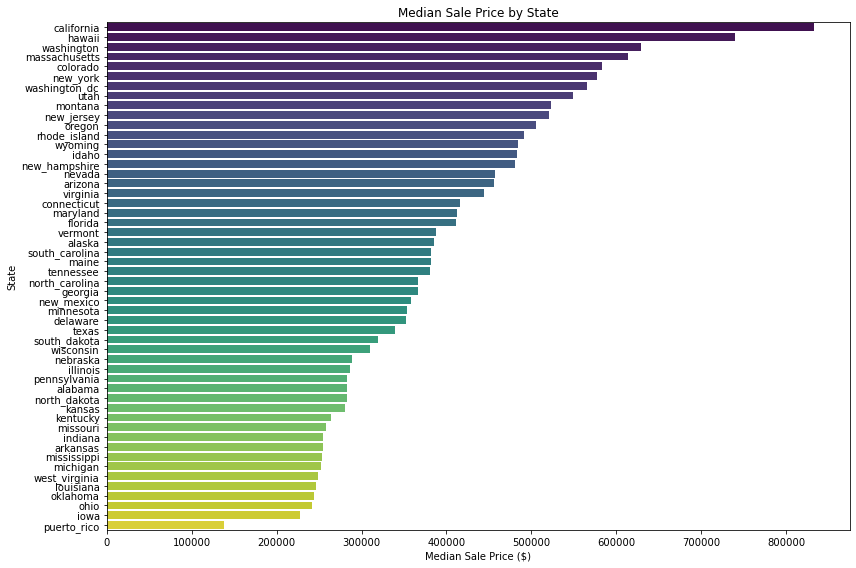

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort by sale price for clearer visualization
df_sorted = merged_df.sort_values('int_msp', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='int_msp', y='key_row', data=df_sorted, palette='viridis')
plt.xlabel('Median Sale Price ($)')
plt.ylabel('State')
plt.title('Median Sale Price by State')
plt.tight_layout()
plt.show()


### Scatter Plot with Regression Line

<Figure size 1008x720 with 0 Axes>

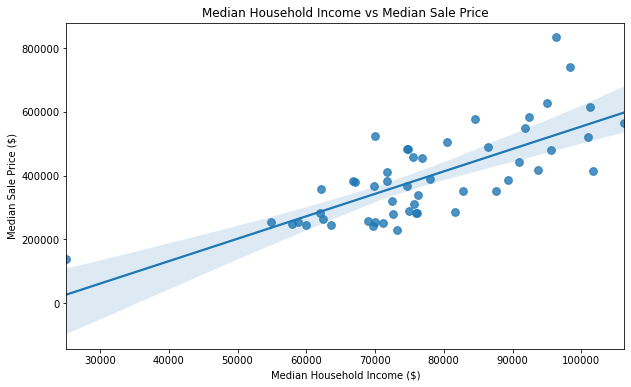

In [9]:
plt.figure(figsize=(14, 10))

plt.figure(figsize=(10,6))
sns.regplot(data=merged_df, x='int_mhi', y='int_msp', scatter_kws={'s':60})
plt.title('Median Household Income vs Median Sale Price')
plt.xlabel('Median Household Income ($)')
plt.ylabel('Median Sale Price ($)')
plt.show()


## Step 7: Export Data to CSV


In [10]:
#drop unnessary columns to match the final output
final_df = merged_df.drop(['census_msa', 'alternative_name', 'redfin_region', 'int_mhi', 'int_msp'], axis=1)

#convert to csv file 
final_df.to_csv('annie_analysis_of_states.csv', index=False)
final_df[:5]

,key_row,census_population,population_rank,population_blurb,median_household_income,median_household_income_rank,median_household_income_blurb,median_sale_price,median_sale_price_rank,median_sale_price_blurb,house_affordability_ratio,house_affordability_ratio_rank,house_affordability_ratio_blurb
0,alabama,"5,108,468",24th,Alabama is 24th in the nation in population am...,"$62,027",47th,Alabama is 47th in the nation in median househ...,"$283,000",37th,Alabama has the 37th highest median sale price...,4.6,24th,Alabama has the 24th lowest house affordabilit...
1,alaska,"733,406",49th,Alaska is 49th in the nation in population amo...,"$89,336",13th,Alaska is 13th in the nation in median househo...,"$385,000",23rd,Alaska has the 23rd highest median sale price ...,4.3,18th,Alaska has the 18th lowest house affordability...
2,arizona,"7,431,344",14th,Arizona is 14th in the nation in population am...,"$76,872",21st,Arizona is 21st in the nation in median househ...,"$456,000",17th,Arizona has the 17th highest median sale price...,5.9,40th,Arizona has the 40th lowest house affordabilit...
3,arkansas,"3,067,732",34th,Arkansas is 34th in the nation in population a...,"$58,773",49th,Arkansas is 49th in the nation in median house...,"$255,000",43rd,Arkansas has the 43rd highest median sale pric...,4.3,18th,Arkansas has the 18th lowest house affordabili...
4,california,"38,965,193",1st,California is 1st in the nation in population ...,"$96,334",6th,California is 6th in the nation in median hous...,"$833,000",1st,California has the 1st highest median sale pri...,8.6,52nd,California has the 52nd lowest house affordabi...
